In [2]:
import esg

In [3]:
import itertools as it

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white",
        palette="pastel",
        color_codes=True,
        rc={'figure.figsize': (12, 9) })

In [5]:
import dotenv, os

dotenv.load_dotenv()

data_path = os.path.join("..", os.environ.get("DATA_PATH"))

esg_path = os.path.join(data_path, "ESG.xlsx")
sheet_name = os.environ.get("SHEET_NAME")

own_path = os.path.join(data_path, "ownership.csv")

saliency_path = os.path.join(data_path, "saliency.csv")

In [6]:
raw = pd.read_excel(esg_path, sheet_name = sheet_name)

get_esg = esg.yearly_esg_maker(raw)

In [7]:
def pct_to_num(pct) -> float:
    """
    Convert 1% to 0.01
    """
    if type(pct) == str:
        return float(pct.replace("%", "")) / 100

    return pct

def parseownershipdata(raw):
    df = raw.dropna(axis = 0, how = 'all').dropna(axis = 1, how = 'all').dropna(axis = 0, how = 'any')

    investors = df.columns[-7:]
    for investor in investors:
        df[investor] = df[investor].apply(pct_to_num)

    return df

In [8]:
ownership = parseownershipdata(pd.read_csv(own_path))
investors = ownership.columns[-7:]

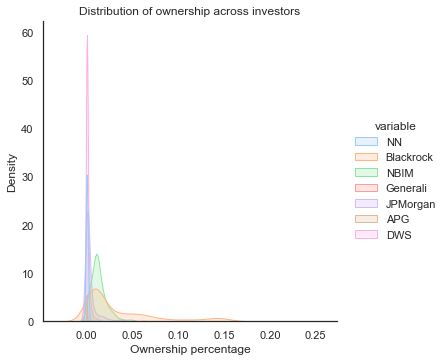

In [9]:
nonzerodf = ownership[investors].melt()
nonzerodf = nonzerodf[nonzerodf['value'] > 0]

sns.displot(data = nonzerodf, x = 'value', hue = 'variable', kind='kde', fill=True)
plt.title("Distribution of ownership across investors")
plt.xlabel("Ownership percentage")
plt.show()

In [59]:
saliency_df = pd.read_csv(saliency_path, index_col = [0, 1])

In [53]:
def makeregressors(saliency_df, ownership, index = 's-index', report = 'STEWARDSHIP_POLICY'):
    S = saliency_df.loc[report, index]
    companies = ownership.columns[-7:]
    X = ownership[companies]
    X.columns = [f"{company} ownership".lower() for company in companies]
    X.index = ownership['TargetFirms']
    N = X.shape[0]

    for company in S.index:
        column_name = f"{company} {report.lower()}"
        X[f"{column_name} interaction"] = X[f"{company} ownership"] * S[company] 
    
    X = sm.add_constant(X, prepend = False, has_constant='add')

    return X

In [54]:
X = makeregressors(saliency_df, ownership)

/var/folders/68/f6hr2xg16v980_3qg7t2l25r0000gn/T/ipykernel_7301/1421384376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{column_name} interaction"] = X[f"{company} ownership"] * S[company]


In [55]:
y = get_esg(2020).loc[X.index]['ESG Combined Score']

In [56]:
model = sm.OLS(y, X)
res = model.fit()

In [57]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ESG Combined Score   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     47.38
Date:                Fri, 29 Oct 2021   Prob (F-statistic):           3.81e-63
Time:                        12:06:02   Log-Likelihood:                -9956.1
No. Observations:                2326   AIC:                         1.993e+04
Df Residuals:                    2318   BIC:                         1.997e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
nn ownership                               191.8183    172.814      1.110      0.267    -147.068     530.705
blackrock ownership                        -44.8322      9.700     -4.622      0.000     -63.853     -25.811
nbim ownership                             529.3738     32.005     16.540      0.000     466.613     592.135
generali ownership                        2.473e+04   8199.633      3.016      0.003    8649.286    4.08e+04
jpmorgan ownership                          65.9762     55.201      1.195      0.232     -42.271     174.224
apg ownership                              127.7694    379.316      0.337      0.736    -616.064     871.603
dws ownership                              364.2070    120.457      3.024      0.003     127.992     600.422
blackrock stewardship_policy interaction    -0.7864      0.170     -4.622      0.000      -1.120      -0.453
dws stewardship_policy interaction           2.0187      0.668      3.024      0.003       0.709       3.328
generali stewardship_policy interaction    148.8949     49.371      3.016      0.003      52.079     245.711
jpmorgan stewardship_policy interaction      0.7196      0.602      1.195      0.232      -0.461       1.900
nn stewardship_policy interaction            1.2342      1.112      1.110      0.267      -0.946       3.415
apg stewardship_policy interaction           1.2056      3.579      0.337      0.736      -5.813       8.224
nbim stewardship_policy interaction          3.4758      0.210     16.540      0.000       3.064       3.888
const                                       37.7509      0.548     68.932      0.000      36.677      38.825
==============================================================================
Omnibus:                        5.536   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.596
Skew:                           0.113   Prob(JB):                       0.0609
Kurtosis:                       2.919   Cond. No.                     5.88e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.73e-41. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [58]:
X

,nn ownership,blackrock ownership,nbim ownership,generali ownership,jpmorgan ownership,apg ownership,dws ownership,blackrock stewardship_policy interaction,dws stewardship_policy interaction,generali stewardship_policy interaction,jpmorgan stewardship_policy interaction,nn stewardship_policy interaction,apg stewardship_policy interaction,nbim stewardship_policy interaction,const
TargetFirms,,,,,,,,,,,,,,,
1-800-FLOWERS.COM'A',0.00000,0.04961,0.00000,0.0,0.00027,0.0,0.00069,0.000870,3.824485e-06,0.0,0.000003,0.000000,0.0,0.000000,1.0
1STSOURCE,0.00000,0.04011,0.01231,0.0,0.00815,0.0,0.00008,0.000704,4.434186e-07,0.0,0.000089,0.000000,0.0,0.000081,1.0
3DSYSTEMS,0.00000,0.14012,0.00418,0.0,0.00000,0.0,0.00247,0.002458,1.369055e-05,0.0,0.000000,0.000000,0.0,0.000027,1.0
3IGROUP,0.00104,0.01047,0.02111,0.0,0.00405,0.0,0.00109,0.000184,6.041578e-06,0.0,0.000044,0.000007,0.0,0.000139,1.0
3PLEARNING,0.00000,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCALER,0.00000,0.02182,0.00482,0.0,0.01880,0.0,0.00036,0.000383,1.995384e-06,0.0,0.000205,0.000000,0.0,0.000032,1.0
ZTE'A',0.00000,0.00106,0.00000,0.0,0.00000,0.0,0.00000,0.000019,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,1.0
ZUMIEZ,0.00000,0.11717,0.00000,0.0,0.01949,0.0,0.00118,0.002055,6.540424e-06,0.0,0.000213,0.000000,0.0,0.000000,1.0
